# MLSMOTE

A python code that implemented the [MLSMOTE](https://www.sciencedirect.com/science/article/abs/pii/S0950705115002737) algorithm was available here: https://github.com/niteshsukhwani/MLSMOTE. However, the code had a bug and wasn't efficiently using the pandas. I fixed and modified the code, and here it is.

**If you find this notebook useful, please don't forget to upvote.**

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

In [59]:
def create_dataset(n_sample=1000):
    ''' 
    Create a unevenly distributed sample data set multilabel  
    classification using make_classification function
    
    args
    nsample: int, Number of sample to be created
    
    return
    X: pandas.DataFrame, feature vector dataframe with 10 features 
    y: pandas.DataFrame, target vector dataframe with 5 labels
    '''
    X, y = make_classification(n_classes=5, class_sep=2,
                               weights=[0.1,0.025, 0.205, 0.008, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                               n_features=10, n_clusters_per_class=1, n_samples=1000, random_state=10)
    y = pd.get_dummies(y, prefix='class')
    return pd.DataFrame(X), y

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    print(irlbl.shape)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    print(irlbl.max())
    print(irlbl.shape)
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    print(threshold_irlbl)
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    print(len(tail_label))
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    print(X_sub.shape, y_sub.shape)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=neigh)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

def SMOLTE_cat_wrapper(x_df, y_df, cat_col, nsamples):
    x_df_up = pd.DataFrame(columns=x_df.columns)
    y_df_up = pd.DataFrame(columns=y_df.columns)

    unique_cat_combs = x_df.groupby(cat_col).size().reset_index().rename(columns={0:'count'})[cat_col]
    num_cols = x_df.columns.drop(cat_col).tolist()
    for index, row in unique_cat_combs.iterrows():
        condition = (x_df[cat_col] == row).all(axis=1)

        subx = x_df[condition][num_cols].reset_index(drop=True)
        suby = y_df[condition].reset_index(drop=True)
        print(subx.shape, suby.shape)

        x_df_sub, y_df_sub = get_minority_samples(subx, suby)
        a, b = MLSMOTE(x_df_sub, y_df_sub, nsamples, neigh=10)
        cats = pd.concat([row.to_frame().T]*len(a), ignore_index=True)
        a = pd.merge(cats, a, how='left', left_index=True, right_index=True)
        x_df_up = x_df_up.append(a, ignore_index=True)
        y_df_up = y_df_up.append(b, ignore_index=True)
    #y_df_up = y_df_up.astype(int)
    
    print('Number of new samples created: %d' %(len(y_df_up)))
    
    x_df_up = pd.concat([x_df, x_df_up], ignore_index=True)
    y_df_up = pd.concat([y_df, y_df_up], ignore_index=True)
    
    x_df_up = x_df_up.sample(len(x_df_up), random_state=1881).reset_index(drop=True)
    y_df_up = y_df_up.sample(len(y_df_up), random_state=1881).reset_index(drop=True)
    
    x_df_up[cat_col] = x_df_up[cat_col].astype(int)
    return x_df_up, y_df_up

In [60]:
def preprocess_df(df):
    if 'cp_type' in df.columns:
        df = df.drop('cp_type', axis=1)
    df['cp_dose'] = (df['cp_dose'] == 'D2').astype(int)
    df['cp_time'] = df['cp_time'].map({24:1, 48: 2, 72: 3})
    return df

In [61]:
train_features = pd.read_csv('data/train_features.csv')
train_target = pd.read_csv('data/train_targets_scored.csv')
print("Original Train sample size:", train_features.shape, ", Original Train target size:", train_target.shape)

train_features = preprocess_df(train_features)

train_features = train_features.drop('sig_id', axis=1)
train_target = train_target.drop('sig_id', axis=1)

cat_col = ['cp_time', 'cp_dose']
x_train_fold, y_train_fold = SMOLTE_cat_wrapper(train_features, train_target, cat_col, nsamples=50)
print("Upsampled Train sample size: %d" % (len(x_train_fold)))
print(x_train_fold.shape, y_train_fold.shape)

Original Train sample size: (23814, 876) , Original Train target size: (23814, 207)
(3886, 872) (3886, 206)
(206,)
122
(183,)
15.25
89
377
(377, 872) (377, 206)


TypeError: cannot unpack non-iterable NoneType object

In [34]:
y_train_fold.tail(5)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
24109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
x = y_train_fold.sum(axis=0).sort_values().reset_index()
x.columns = ['column', 'nonzero_records']

import plotly.express as px
import plotly
fig = px.bar(
    x[:], 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='', 
    height=1000, 
    width=800
)
df_scr_target = x
# fig.show()
plotly.offline.iplot(fig, filename='top_50.png')

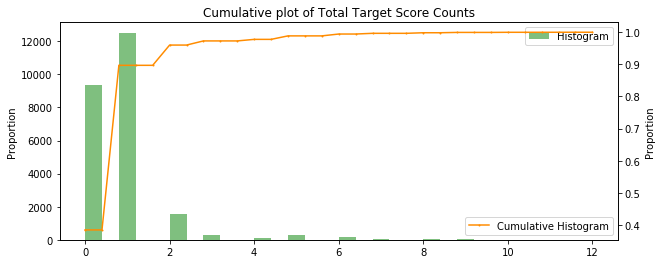

In [30]:
import matplotlib.pyplot as plt

def hist(data, bins, title, labels, range = None):
    fig = plt.figure(figsize=(10, 4))
    ax = plt.axes()
    plt.ylabel("Proportion")
    values, base, _ = plt.hist(data, bins = bins, alpha = 0.5, color = "green", range = range, 
                               label = "Histogram")
    ax_bis = ax.twinx()
    values = np.append(values,0)
    ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-',
                markersize = 1, label = "Cumulative Histogram" )
    plt.xlabel(labels)
    plt.ylabel("Proportion")
    plt.title(title)
    ax_bis.legend();
    ax.legend();
    plt.show()
    return

features = y_train_fold.columns.values[1:]
data = y_train_fold[features].sum(axis=1)
hist(data, 30, 'Cumulative plot of Total Target Score Counts', 'label')

In [4]:
train_features = pd.read_csv('data/train_features.csv')
train_target = pd.read_csv('data/train_targets_scored.csv')
train_features = pd.concat((train_features, pd.get_dummies(train_features[['cp_type', 'cp_dose']])), axis=1)
train_features = train_features.drop('cp_type', axis=1)
train_features = train_features.drop('cp_dose', axis=1)
X = train_features.drop('sig_id', axis=1)
y = train_target.drop('sig_id', axis=1)
#X = X.drop('cp_time', axis=1)
print(X.head())
#X, y = create_dataset()  # Creating a Dataframe
X_sub, y_sub = get_minority_samples(X, y)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 13814, 5)  # Applying MLSMOTE to augment the dataframe

   cp_time     g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7  \
0       24  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326   
1       72  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341  0.3372   
2       48  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715  0.2155   
3       48 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095 -1.9590  0.1792   
4       72 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244 -0.2800 -0.1498   

      g-8  ...    c-94    c-95    c-96    c-97    c-98    c-99  \
0  0.5548  ... -0.1912  0.6584 -0.3981  0.2139  0.3801  0.4176   
1 -0.4047  ...  0.2957  0.4899  0.1522  0.1241  0.6077  0.7371   
2  0.0065  ... -1.3240 -0.3174 -0.6417 -0.2187 -1.4080  0.6931   
3 -0.1321  ... -0.8632 -1.2880 -1.6210 -0.8784 -0.3876 -0.8154   
4 -0.8789  ...  0.5523 -0.3031  0.1094  0.2885 -0.3786  0.7125   

   cp_type_ctl_vehicle  cp_type_trt_cp  cp_dose_D1  cp_dose_D2  
0                    0               1           1           0  
1   

In [5]:
y_res.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
X_res.head()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-94,c-95,c-96,c-97,c-98,c-99,cp_type_ctl_vehicle,cp_type_trt_cp,cp_dose_D1,cp_dose_D2
0,48.0,-0.427355,-1.740022,-0.909689,0.844154,-1.057840,-1.660298,-2.039536,-1.044221,0.976831,...,-0.332407,-0.357842,0.554371,0.678160,0.931498,-1.258546,0.0,1.0,1.0,0.0
1,24.0,-0.480671,-1.379930,1.966963,0.294511,-0.911900,-1.426821,-0.039877,-0.388419,-1.234398,...,1.310362,1.026126,-0.007254,0.679646,1.152246,-0.675738,0.0,1.0,0.0,1.0
2,48.0,0.649178,-0.004089,1.077053,-1.407253,0.896342,-2.166080,2.620874,-0.380833,3.228314,...,-0.107723,-0.892554,0.436533,0.892713,0.110578,-0.690416,0.0,1.0,0.0,1.0
3,24.0,1.460298,-0.272887,1.095552,-5.056620,-0.515946,-1.587886,4.124922,0.054473,2.395300,...,-1.333891,-2.782389,-1.203081,-0.140034,-1.556177,-0.532991,0.0,1.0,0.0,1.0
4,24.0,-1.173705,1.058488,2.874453,2.244023,2.221511,-0.314731,0.436182,0.476150,-3.920565,...,1.301848,-0.674510,0.566476,-1.848730,-0.990500,0.846660,0.0,1.0,1.0,0.0


In [7]:
X_res.shape, y_res.shape

((13814, 877), (13814, 206))

In [8]:
x = train_features['sig_id']
x = pd.concat((x, X_res), axis=1)
df_train_label_scr = pd.concat((train_target['sig_id'], y_res), axis=1)
x.shape, df_train_label_scr.shape

((23814, 878), (23814, 207))

In [11]:
x = df_train_label_scr.drop(['sig_id'], axis=1).sum(axis=0).sort_values().reset_index()
x.columns = ['column', 'nonzero_records']

import plotly.express as px
import plotly
fig = px.bar(
    x, 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='Columns with the higher number of positive samples (top 50) in scored dataset', 
    height=2000, 
    width=800
)
df_scr_target = x
# fig.show()
plotly.offline.iplot(fig, filename='top_50.png')

# fig.write_image("top_50.png")

In [11]:
df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100]]),
                  columns=['a', 'b'])
df.head()

,a,b
0,1,1
1,2,10
2,3,100
3,4,100


In [12]:
df.quantile([.1, .5])

,a,b
0.1,1.3,3.7
0.5,2.5,55.0
